# 02. 피처 엔지니어링

**목표:** 수집된 OHLCV 데이터에 기술적 지표 및 파생 피처를 추가하고 정규화까지 완료

```
[ 입력 ]  data/splits/train.csv, val.csv, test.csv  (OHLCV)
[ 출력 ]  data/processed/train.csv, val.csv, test.csv  (피처 추가 + 정규화)
          data/processed/scaler.pkl  (정규화 파라미터 저장)
```

**추가할 피처 목록**
- 수익률 계열: 로그수익률, 변화율
- 트렌드 계열: EMA(9, 21, 50, 200), MACD, ADX
- 모멘텀 계열: RSI(14), Stochastic RSI, CCI, Williams %R, ROC
- 변동성 계열: Bollinger Band, ATR, Keltner Channel
- 거래량 계열: OBV, 거래량 변화율, MFI
- 캔들 패턴: 몸통 크기, 윗꼬리/아랫꼬리 비율
- 시간 피처: 요일, 시간대 (sin/cos 인코딩)

## 1. Import 및 데이터 로드

In [7]:
# sklearn 없으면 설치
# !pip install scikit-learn

In [8]:
import pandas as pd
import numpy as np
import ta
import os
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler

print(f"pandas : {pd.__version__}")
print(f"ta     : OK")

pandas : 3.0.1
ta     : OK


In [9]:
# ─────────────────────────────────────────────
#  경로 설정
# ─────────────────────────────────────────────
SPLIT_DIR     = '../data/splits'
PROCESSED_DIR = '../data/processed'
os.makedirs(PROCESSED_DIR, exist_ok=True)

def load_split(name: str) -> pd.DataFrame:
    path = os.path.join(SPLIT_DIR, f'{name}.csv')
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    return df

df_train = load_split('train')
df_val   = load_split('val')
df_test  = load_split('test')

print(f"Train  : {len(df_train):,}개  ({df_train.index[0].date()} ~ {df_train.index[-1].date()})")
print(f"Val    : {len(df_val):,}개  ({df_val.index[0].date()} ~ {df_val.index[-1].date()})")
print(f"Test   : {len(df_test):,}개  ({df_test.index[0].date()} ~ {df_test.index[-1].date()})")

Train  : 48,159개  (2018-01-01 ~ 2023-06-30)
Val    : 6,600개  (2023-07-01 ~ 2024-03-31)
Test   : 16,579개  (2024-04-01 ~ 2026-02-20)


## 2. 피처 계산 함수 정의

> 이 함수는 학습/실전 모두 동일하게 사용합니다.  
> 나중에 실전 배포 시 이 함수를 그대로 가져다 쓰면 됩니다.

In [10]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    OHLCV DataFrame에 기술적 지표 및 파생 피처를 추가합니다.
    학습/실전 모두 이 함수를 동일하게 사용합니다.
    """
    df = df.copy()
    
    close  = df['close']
    high   = df['high']
    low    = df['low']
    volume = df['volume']
    
    # ─────────────────────────────────────────
    #  [1] 수익률 계열
    # ─────────────────────────────────────────
    # 로그 수익률 (정규분포에 가까워 RL에 유리)
    df['log_return_1']  = np.log(close / close.shift(1))   # 1시간
    df['log_return_4']  = np.log(close / close.shift(4))   # 4시간
    df['log_return_24'] = np.log(close / close.shift(24))  # 1일
    
    # ─────────────────────────────────────────
    #  [2] 트렌드 계열
    # ─────────────────────────────────────────
    # EMA - 절대값 대신 가격 대비 비율로 변환 (정규화에 유리)
    df['ema_9']   = ta.trend.EMAIndicator(close, window=9).ema_indicator()
    df['ema_21']  = ta.trend.EMAIndicator(close, window=21).ema_indicator()
    df['ema_50']  = ta.trend.EMAIndicator(close, window=50).ema_indicator()
    df['ema_200'] = ta.trend.EMAIndicator(close, window=200).ema_indicator()
    
    df['ema_9_ratio']   = close / df['ema_9'] - 1
    df['ema_21_ratio']  = close / df['ema_21'] - 1
    df['ema_50_ratio']  = close / df['ema_50'] - 1
    df['ema_200_ratio'] = close / df['ema_200'] - 1
    
    # MACD
    macd_obj = ta.trend.MACD(close, window_slow=26, window_fast=12, window_sign=9)
    df['macd']        = macd_obj.macd()
    df['macd_signal'] = macd_obj.macd_signal()
    df['macd_hist']   = macd_obj.macd_diff()
    
    # ADX (추세 강도)
    adx_obj = ta.trend.ADXIndicator(high, low, close, window=14)
    df['adx']     = adx_obj.adx()
    df['adx_pos'] = adx_obj.adx_pos()
    df['adx_neg'] = adx_obj.adx_neg()
    
    # ─────────────────────────────────────────
    #  [3] 모멘텀 계열
    # ─────────────────────────────────────────
    df['rsi_14'] = ta.momentum.RSIIndicator(close, window=14).rsi()
    df['rsi_7']  = ta.momentum.RSIIndicator(close, window=7).rsi()
    
    stoch_rsi = ta.momentum.StochRSIIndicator(close, window=14, smooth1=3, smooth2=3)
    df['stoch_rsi_k'] = stoch_rsi.stochrsi_k()
    df['stoch_rsi_d'] = stoch_rsi.stochrsi_d()
    
    df['cci']        = ta.trend.CCIIndicator(high, low, close, window=20).cci()
    df['williams_r'] = ta.momentum.WilliamsRIndicator(high, low, close, lbp=14).williams_r()
    df['roc_9']      = ta.momentum.ROCIndicator(close, window=9).roc()
    df['roc_21']     = ta.momentum.ROCIndicator(close, window=21).roc()
    
    # ─────────────────────────────────────────
    #  [4] 변동성 계열
    # ─────────────────────────────────────────
    bb = ta.volatility.BollingerBands(close, window=20, window_dev=2)
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_lower'] = bb.bollinger_lband()
    df['bb_mid']   = bb.bollinger_mavg()
    df['bb_width'] = bb.bollinger_wband()
    df['bb_pct']   = bb.bollinger_pband()
    
    df['atr_14']    = ta.volatility.AverageTrueRange(high, low, close, window=14).average_true_range()
    df['atr_ratio'] = df['atr_14'] / close
    
    kc = ta.volatility.KeltnerChannel(high, low, close, window=20)
    df['kc_upper'] = kc.keltner_channel_hband()
    df['kc_lower'] = kc.keltner_channel_lband()
    df['kc_pct']   = kc.keltner_channel_pband()
    
    # ─────────────────────────────────────────
    #  [5] 거래량 계열
    # ─────────────────────────────────────────
    df['obv']           = ta.volume.OnBalanceVolumeIndicator(close, volume).on_balance_volume()
    df['volume_change'] = volume.pct_change()
    df['volume_ma20']   = volume.rolling(20).mean()
    df['volume_ratio']  = volume / df['volume_ma20']
    df['mfi']           = ta.volume.MFIIndicator(high, low, close, volume, window=14).money_flow_index()
    
    # ─────────────────────────────────────────
    #  [6] 캔들 패턴 피처
    # ─────────────────────────────────────────
    df['candle_body'] = (df['close'] - df['open']) / df['open']
    candle_range      = df['high'] - df['low'] + 1e-9
    df['upper_wick']  = (df['high'] - df[['open','close']].max(axis=1)) / candle_range
    df['lower_wick']  = (df[['open','close']].min(axis=1) - df['low']) / candle_range
    
    # ─────────────────────────────────────────
    #  [7] 시간 피처 (sin/cos 인코딩)
    # ─────────────────────────────────────────
    # 23시와 0시가 가깝다는 주기성을 표현하기 위해 sin/cos 사용
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['dow_sin']  = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['dow_cos']  = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # ─────────────────────────────────────────
    #  절대값 컬럼 제거 (상대값/비율로 대체)
    #  close는 RL 환경에서 수익 계산에 필요하므로 유지
    # ─────────────────────────────────────────
    cols_to_drop = [
        'open', 'high', 'low',
        'ema_9', 'ema_21', 'ema_50', 'ema_200',
        'bb_upper', 'bb_lower', 'bb_mid',
        'kc_upper', 'kc_lower',
        'volume_ma20',
        'atr_14',
    ]
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
    return df

print("피처 계산 함수 정의 완료")

피처 계산 함수 정의 완료


## 3. 피처 계산 실행

In [11]:
print("피처 계산 중...")
df_train_feat = add_features(df_train)
df_val_feat   = add_features(df_val)
df_test_feat  = add_features(df_test)

print(f"피처 계산 완료")
print(f"Train 피처 수 : {len(df_train_feat.columns)}개")
print(f"컬럼 목록:")
for i, col in enumerate(df_train_feat.columns):
    print(f"  {i+1:2d}. {col}")

피처 계산 중...
피처 계산 완료
Train 피처 수 : 38개
컬럼 목록:
   1. close
   2. volume
   3. log_return_1
   4. log_return_4
   5. log_return_24
   6. ema_9_ratio
   7. ema_21_ratio
   8. ema_50_ratio
   9. ema_200_ratio
  10. macd
  11. macd_signal
  12. macd_hist
  13. adx
  14. adx_pos
  15. adx_neg
  16. rsi_14
  17. rsi_7
  18. stoch_rsi_k
  19. stoch_rsi_d
  20. cci
  21. williams_r
  22. roc_9
  23. roc_21
  24. bb_width
  25. bb_pct
  26. atr_ratio
  27. kc_pct
  28. obv
  29. volume_change
  30. volume_ratio
  31. mfi
  32. candle_body
  33. upper_wick
  34. lower_wick
  35. hour_sin
  36. hour_cos
  37. dow_sin
  38. dow_cos


In [12]:
# 앞부분 NaN 제거 (EMA 200 등 긴 윈도우 계산에 필요한 초기 데이터)
before_train = len(df_train_feat)

df_train_feat.dropna(inplace=True)
df_val_feat.dropna(inplace=True)
df_test_feat.dropna(inplace=True)

print(f"Train NaN 제거: {before_train:,} → {len(df_train_feat):,}개")
print(f"Val   : {len(df_val_feat):,}개")
print(f"Test  : {len(df_test_feat):,}개")
print(f"\n남은 NaN 수: {df_train_feat.isnull().sum().sum()}")

Train NaN 제거: 48,159 → 47,863개
Val   : 6,401개
Test  : 16,380개

남은 NaN 수: 0


## 4. 정규화 (Scaling)

**RobustScaler를 선택한 이유**  
비트코인은 가격 급등락이 잦아 극단값(outlier)이 많습니다.  
StandardScaler는 극단값에 민감하지만, RobustScaler는 중앙값(median)과 IQR 기반이라 극단값에 강건합니다.

**핵심 원칙: Train 데이터로만 `fit()` → Val/Test는 `transform()`만 적용**

In [13]:
# 정규화 제외 컬럼
# - sin/cos: 이미 -1~1 범위
# - close: RL 환경에서 수익 계산에 원본값 필요
EXCLUDE_COLS = ['close', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
SCALE_COLS   = [c for c in df_train_feat.columns if c not in EXCLUDE_COLS]

print(f"정규화 대상: {len(SCALE_COLS)}개 컬럼")
print(f"정규화 제외: {EXCLUDE_COLS}")

정규화 대상: 33개 컬럼
정규화 제외: ['close', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


In [15]:
# inf 값 제거 (volume_ratio 등 나눗셈 피처에서 발생)
df_train_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
df_val_feat.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test_feat.replace([np.inf, -np.inf], np.nan, inplace=True)

df_train_feat.dropna(inplace=True)
df_val_feat.dropna(inplace=True)
df_test_feat.dropna(inplace=True)

print(f"Train : {len(df_train_feat):,}개")
print(f"Val   : {len(df_val_feat):,}개")
print(f"Test  : {len(df_test_feat):,}개")
print(f"남은 inf : {np.isinf(df_train_feat.values).sum()}")
print(f"남은 NaN : {df_train_feat.isnull().sum().sum()}")

# Train으로만 fit
scaler = RobustScaler()
scaler.fit(df_train_feat[SCALE_COLS])

def apply_scaling(df, scaler, scale_cols):
    df = df.copy()
    df[scale_cols] = scaler.transform(df[scale_cols])
    return df

df_train_scaled = apply_scaling(df_train_feat, scaler, SCALE_COLS)
df_val_scaled   = apply_scaling(df_val_feat,   scaler, SCALE_COLS)
df_test_scaled  = apply_scaling(df_test_feat,  scaler, SCALE_COLS)

print("✅ 정규화 완료")
print("\n정규화 후 주요 피처 통계:")
df_train_scaled[['log_return_1', 'rsi_14', 'macd_hist', 'bb_pct', 'volume_ratio']].describe().round(3)

Train : 47,836개
Val   : 6,401개
Test  : 16,380개
남은 inf : 0
남은 NaN : 0
✅ 정규화 완료

정규화 후 주요 피처 통계:


,log_return_1,rsi_14,macd_hist,bb_pct,volume_ratio
count,47836.000,47836.000,47836.000,47836.000,47836.000
mean,-0.011,-0.003,-0.002,-0.021,0.311
std,1.479,0.792,2.153,0.671,1.165
min,-36.690,-2.945,-21.676,-2.197,-1.532
25%,-0.503,-0.508,-0.506,-0.519,-0.385
50%,0.000,-0.000,0.000,-0.000,0.000
75%,0.497,0.492,0.494,0.481,0.615
max,29.228,2.913,19.205,2.110,16.688


## 5. 피처 분포 시각화

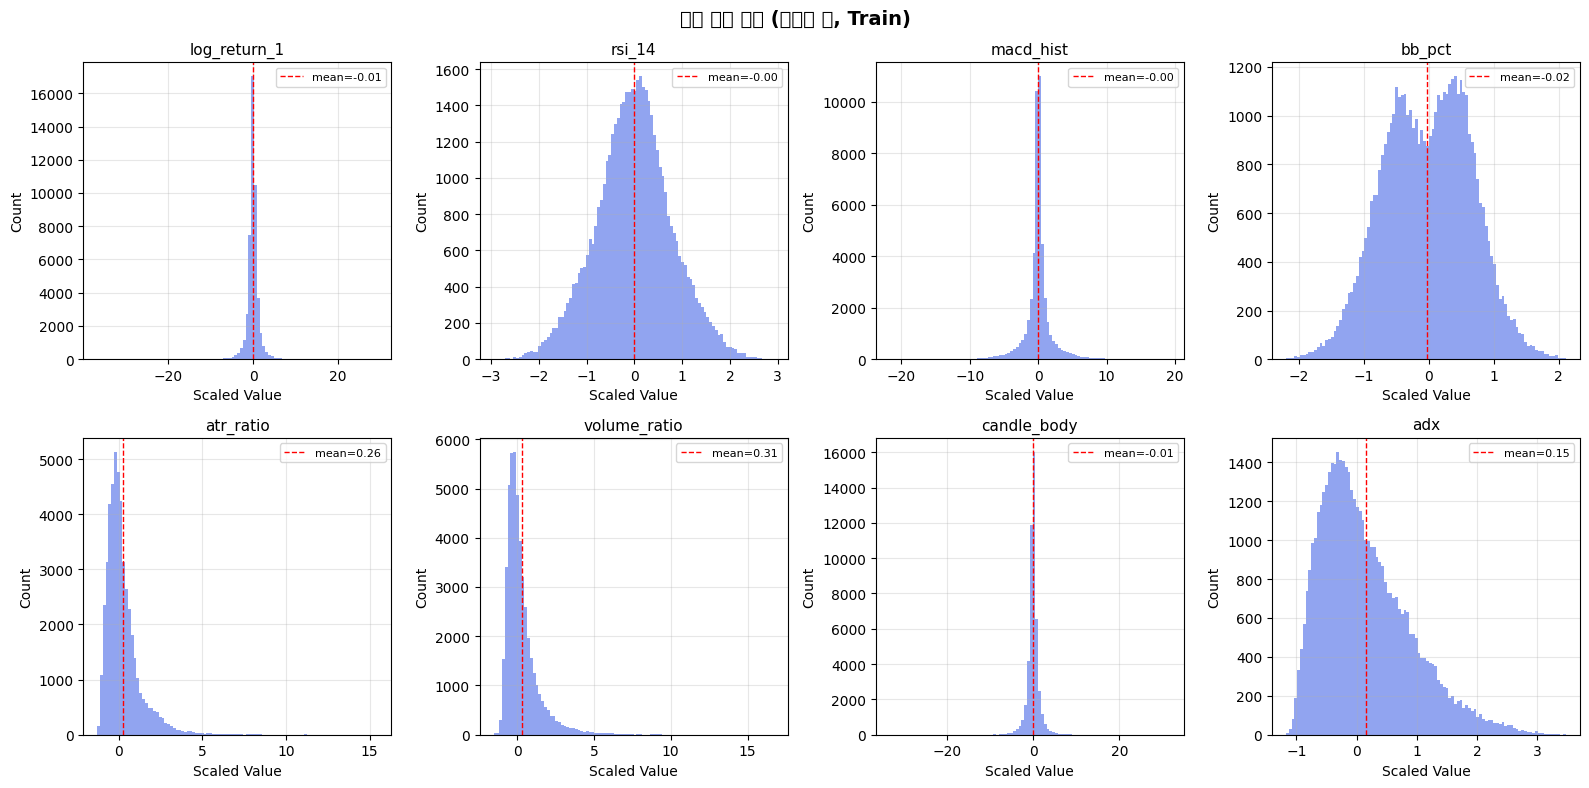

In [16]:
key_features = ['log_return_1', 'rsi_14', 'macd_hist', 'bb_pct',
                'atr_ratio', 'volume_ratio', 'candle_body', 'adx']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(key_features):
    axes[i].hist(df_train_scaled[col].dropna(), bins=100, color='#627EEA', alpha=0.7, edgecolor='none')
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('Scaled Value')
    axes[i].set_ylabel('Count')
    axes[i].grid(alpha=0.3)
    mean = df_train_scaled[col].mean()
    axes[i].axvline(mean, color='red', linestyle='--', linewidth=1, label=f'mean={mean:.2f}')
    axes[i].legend(fontsize=8)

plt.suptitle('주요 피처 분포 (정규화 후, Train)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR, 'feature_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

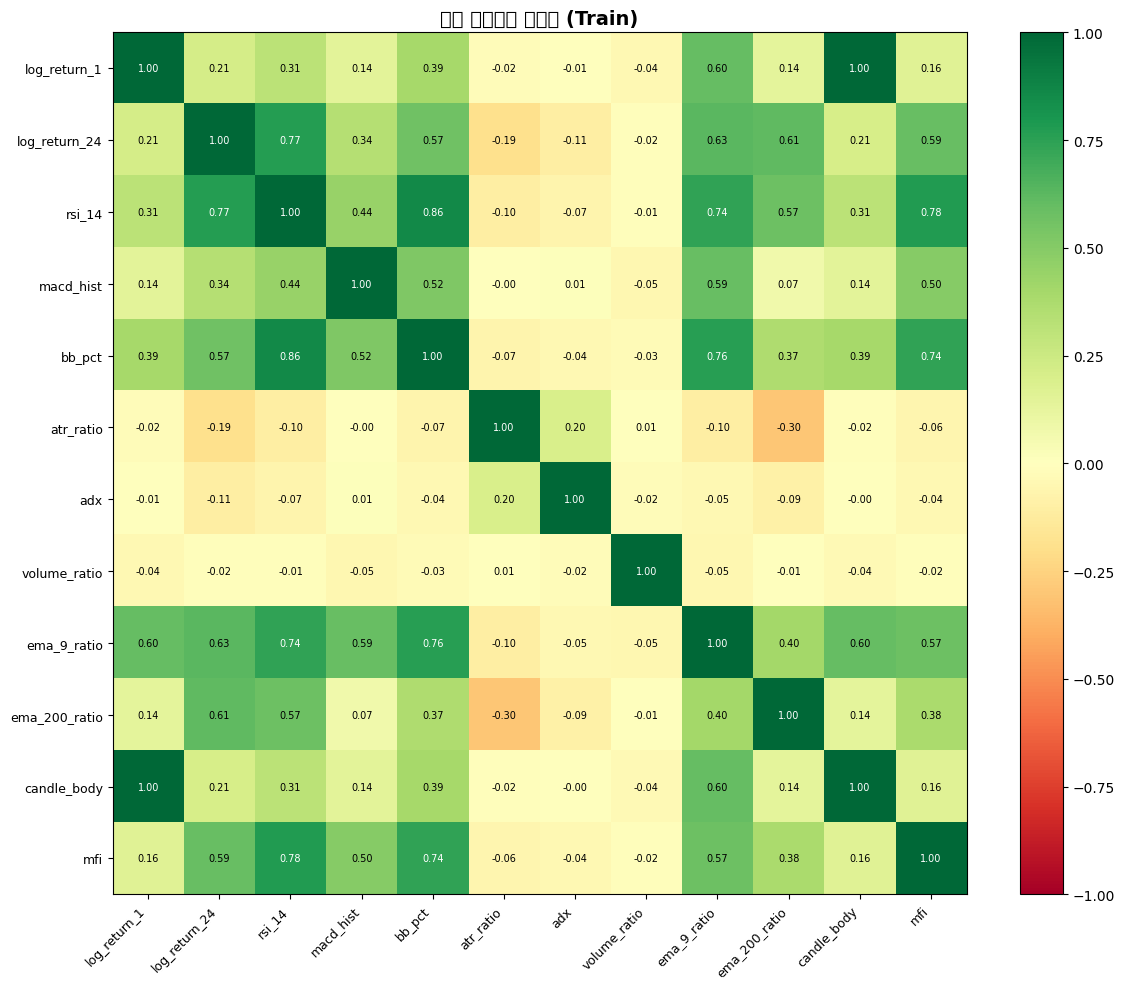

In [17]:
# 피처 상관관계 히트맵
corr_features = ['log_return_1', 'log_return_24', 'rsi_14', 'macd_hist',
                 'bb_pct', 'atr_ratio', 'adx', 'volume_ratio',
                 'ema_9_ratio', 'ema_200_ratio', 'candle_body', 'mfi']

corr_matrix = df_train_scaled[corr_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(im)

ax.set_xticks(range(len(corr_features)))
ax.set_yticks(range(len(corr_features)))
ax.set_xticklabels(corr_features, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(corr_features, fontsize=9)

for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        val = corr_matrix.iloc[i, j]
        color = 'white' if abs(val) > 0.7 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=7, color=color)

plt.title('피처 상관관계 히트맵 (Train)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR, 'feature_correlation.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. 저장

In [18]:
# 처리된 데이터 저장
df_train_scaled.to_csv(os.path.join(PROCESSED_DIR, 'train.csv'))
df_val_scaled.to_csv(os.path.join(PROCESSED_DIR, 'val.csv'))
df_test_scaled.to_csv(os.path.join(PROCESSED_DIR, 'test.csv'))

# Scaler 저장 (실전 배포 시 반드시 동일한 scaler를 사용해야 함)
scaler_path = os.path.join(PROCESSED_DIR, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump({
        'scaler': scaler,
        'scale_cols': SCALE_COLS,
        'exclude_cols': EXCLUDE_COLS,
    }, f)

print("✅ 저장 완료!")
print(f"  Train  : {len(df_train_scaled):,}행 x {len(df_train_scaled.columns)}열")
print(f"  Val    : {len(df_val_scaled):,}행 x {len(df_val_scaled.columns)}열")
print(f"  Test   : {len(df_test_scaled):,}행 x {len(df_test_scaled.columns)}열")
print(f"  Scaler : {scaler_path}")

✅ 저장 완료!
  Train  : 47,836행 x 38열
  Val    : 6,401행 x 38열
  Test   : 16,380행 x 38열
  Scaler : ../data/processed\scaler.pkl


## 7. 최종 검증

In [19]:
df_check = pd.read_csv(os.path.join(PROCESSED_DIR, 'train.csv'), index_col=0, parse_dates=True)

print("=" * 50)
print("✅ 최종 검증")
print("=" * 50)
print(f"행 수    : {len(df_check):,}개")
print(f"컬럼 수  : {len(df_check.columns)}개")
print(f"NaN 수   : {df_check.isnull().sum().sum()}")
print()
df_check.head(3)

✅ 최종 검증
행 수    : 47,836개
컬럼 수  : 38개
NaN 수   : 0



,close,volume,log_return_1,log_return_4,log_return_24,ema_9_ratio,ema_21_ratio,ema_50_ratio,ema_200_ratio,macd,...,volume_change,volume_ratio,mfi,candle_body,upper_wick,lower_wick,hour_sin,hour_cos,dow_sin,dow_cos
2018-01-09 16:00:00+09:00,15062.28,-0.603551,2.633908,-0.924233,-1.589056,0.214029,-0.204099,-1.038358,-0.188418,-1.147930,...,-0.755300,-0.876579,0.238835,2.655465,0.113546,-0.838246,-0.866025,-5.000000e-01,0.781831,0.62349
2018-01-09 17:00:00+09:00,15190.56,-0.615119,1.533487,-0.981558,-0.588564,1.110265,0.400128,-0.661088,-0.036411,-0.949575,...,-0.084942,-0.917107,0.150005,1.541394,0.389278,-0.227075,-0.965926,-2.588190e-01,0.781831,0.62349
2018-01-09 18:00:00+09:00,14811.00,-0.591815,-4.630134,-0.449038,0.305390,-1.921737,-1.383253,-1.640422,-0.481000,-1.064342,...,0.389867,-0.765505,-0.090603,-4.575276,-0.778010,-0.557858,-1.000000,-1.836970e-16,0.781831,0.62349


In [20]:
# Scaler 로드 검증
with open(scaler_path, 'rb') as f:
    saved = pickle.load(f)

print(f"Scaler 타입    : {type(saved['scaler']).__name__}")
print(f"정규화 컬럼 수 : {len(saved['scale_cols'])}개")
print(f"제외 컬럼     : {saved['exclude_cols']}")
print("\n✅ Scaler 로드 성공")

Scaler 타입    : RobustScaler
정규화 컬럼 수 : 33개
제외 컬럼     : ['close', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

✅ Scaler 로드 성공


---

## ✅ 완료 요약

| 카테고리 | 피처 | 상태 |
|---|---|---|
| 수익률 | log_return 1h / 4h / 24h | ✅ |
| 트렌드 | EMA ratio(9/21/50/200), MACD, ADX | ✅ |
| 모멘텀 | RSI(7/14), Stoch RSI, CCI, Williams %R, ROC | ✅ |
| 변동성 | Bollinger Band, ATR ratio, Keltner Channel | ✅ |
| 거래량 | OBV, Volume ratio, MFI | ✅ |
| 캔들 | Body, Upper/Lower Wick | ✅ |
| 시간 | Hour / DoW sin-cos 인코딩 | ✅ |
| 정규화 | RobustScaler (Train fit 후 저장) | ✅ |

**다음 단계:** `03_rl_environment.ipynb` — OpenAI Gym 기반 트레이딩 환경 구현